In [1]:
import os
import csv
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import v2 as T
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix)
import seaborn as sns

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng thiết bị: {device}")

Sử dụng thiết bị: cuda


In [3]:
class DynamicGraphAttention(nn.Module):
    def __init__(self, in_channels, num_nodes=32, heads=8, dropout=0.1):  # Tăng num_nodes/heads mặc định
        super().__init__()
        self.num_nodes = num_nodes
        self.heads = heads
        self.head_dim = in_channels // heads
        self.dropout = nn.Dropout(dropout)

        self.query = nn.Linear(in_channels, in_channels)
        self.key = nn.Linear(in_channels, in_channels)
        self.value = nn.Linear(in_channels, in_channels)
        self.out = nn.Linear(in_channels, in_channels)
        self.scale = nn.Parameter(torch.tensor(self.head_dim**-0.5))

        # Positional encoding (simple learnable)
        self.pos_enc = nn.Parameter(torch.randn(1, num_nodes, in_channels))

    def forward(self, x):
        B, C, H, W = x.size()
        x_flat = x.flatten(2).transpose(1, 2)  # (B, H*W, C)
        
        num_pixels = H * W
        N = min(self.num_nodes, num_pixels)
        
        # Importance sampling: Chọn top-k pixels dựa trên L2 norm (thay vì random/linspace)
        norms = torch.norm(x_flat, dim=-1)  # (B, H*W)
        _, indices = torch.topk(norms, N, dim=-1)  # Top-k indices
        indices = indices.sort(dim=-1).indices  # Sort để ổn định
        x_nodes = torch.gather(x_flat, 1, indices.unsqueeze(-1).expand(-1, -1, C))  # (B, N, C)
        
        # Thêm positional encoding
        x_nodes = x_nodes + self.pos_enc.expand(B, -1, -1)
        
        q = self.query(x_nodes).view(B, N, self.heads, self.head_dim).transpose(1, 2)
        k = self.key(x_nodes).view(B, N, self.heads, self.head_dim).transpose(1, 2)
        v = self.value(x_nodes).view(B, N, self.heads, self.head_dim).transpose(1, 2)
        
        attn_weights = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        attn_weights = F.softmax(attn_weights, dim=-1)
        attn_weights = self.dropout(attn_weights)  # Thêm dropout
        attn_output = torch.matmul(attn_weights, v)
        attn_output = attn_output.transpose(1, 2).contiguous().view(B, N, C)
        
        out_nodes = self.out(attn_output)
        
        out_flat = torch.zeros_like(x_flat)
        out_flat.scatter_(1, indices.unsqueeze(-1).expand(-1, -1, C), out_nodes)
        out = out_flat.transpose(1, 2).view(B, C, H, W)
        
        return x + out  # Residual connection

class TemporalAttentionAggregator(nn.Module):
    def __init__(self, in_channels, num_heads=4):
        super().__init__()
        self.attention_net = nn.MultiheadAttention(embed_dim=in_channels, num_heads=num_heads)  # Thay MLP bằng MultiheadAttention
        self.norm = nn.LayerNorm(in_channels)

    def forward(self, x):
        if len(x.shape) == 4:  # (B, C, H, W) -> Giả sử single frame, flatten spatial
            B, C, H, W = x.size()
            x_flat = x.flatten(2).transpose(1, 2)  # (B, H*W, C)
        elif len(x.shape) == 5:  # (B, T, C, H, W) -> Flatten temporal-spatial
            B, T, C, H, W = x.size()
            x_flat = x.flatten(3).transpose(2, 3).reshape(B, T * H * W, C)  # (B, T*H*W, C)
        else:
            raise ValueError("Input must be 4D or 5D tensor")
        
        # Temporal-spatial attention
        x_flat = self.norm(x_flat)
        attn_output, _ = self.attention_net(x_flat, x_flat, x_flat)  # Self-attention
        
        # Aggregate
        aggregated_vector = torch.mean(attn_output, dim=1)  # Mean pooling thay sum để ổn định
        return aggregated_vector

class InvertedResidual(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expansion=6):  # Tăng expansion mặc định
        super().__init__()
        hidden_dim = in_channels * expansion
        self.use_residual = in_channels == out_channels and stride == 1
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, hidden_dim, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.SiLU(inplace=True),  # Thay ReLU6 bằng SiLU (Swish)
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.SiLU(inplace=True),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )
        
        # Thêm SE block
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(out_channels, out_channels // 16, 1),
            nn.SiLU(),
            nn.Conv2d(out_channels // 16, out_channels, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.conv(x)
        out = out * self.se(out)  # Áp dụng SE
        return x + out if self.use_residual else out

In [4]:
class PestLarvaNet_Large(nn.Module):
    def __init__(self, num_classes, input_channels=1):
        super().__init__()
        self.config = [[1, 32, 2, 1], [6, 48, 3, 2], [6, 80, 4, 2], [6, 128, 3, 2], [6, 192, 3, 1]]
        self.stem = nn.Sequential(
            nn.Conv2d(input_channels, 32, 3, 2, 1, bias=False),
            nn.BatchNorm2d(32), nn.SiLU(inplace=True))
        
        layers = []
        in_channels = 32
        for t, c, n, s in self.config:
            for i in range(n):
                stride = s if i == 0 else 1
                layers.append(InvertedResidual(in_channels, c, stride, expansion=t))
                in_channels = c
            if c == 48:
                layers.append(DynamicGraphAttention(in_channels, num_nodes=40, heads=8))
        self.body = nn.Sequential(*layers)
        
        self.head_conv = nn.Conv2d(192, 512, 1, bias=False)
        self.aggregator = TemporalAttentionAggregator(512, num_heads=8)
        self.classifier = nn.Sequential(
            nn.Linear(512, 256), nn.SiLU(inplace=True), nn.Dropout(0.5),
            nn.Linear(256, num_classes))

    def forward(self, x):
        x = self.stem(x); x = self.body(x); x = self.head_conv(x)
        x = self.aggregator(x); x = self.classifier(x); return x

In [5]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

In [6]:
class InsectSpectrogramDataset(Dataset):
    """Dataset tùy chỉnh để đọc các file spectrogram .pt"""
    def __init__(self, metadata_file, data_dir, transform=None):
        self.metadata = pd.read_csv(metadata_file)
        self.data_dir = data_dir
        self.transform = transform
        self.file_column = 'file_name'
        self.label_column = 'label'
        
        self.class_names = sorted(self.metadata[self.label_column].unique())
        self.class_to_id = {name: i for i, name in enumerate(self.class_names)}
        self.id_to_class = {i: name for name, i in self.class_to_id.items()}

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        file_name = self.metadata.iloc[idx][self.file_column]
        file_path = os.path.join(self.data_dir, file_name)
        label_name = self.metadata.iloc[idx][self.label_column]
        label = self.class_to_id[label_name]
        
        try:
            spectrogram = torch.load(file_path)
            if spectrogram.dim() == 2:
                spectrogram = spectrogram.unsqueeze(0)
            if self.transform:
                spectrogram = self.transform(spectrogram)
            return spectrogram, label
        except Exception as e:
            print(f"Lỗi khi tải file {file_path}: {e}")
            return torch.zeros(1, 128, 259), -1 # Trả về mẫu lỗi

In [7]:
METADATA_PATH = r'F:/Working Sync/LAB projects/InsectSELD/Dataset/metadata_Mel.csv' 
DATA_DIR = r'F:/Working Sync/LAB projects/InsectSELD/Dataset/MelSpectrograms'

In [8]:
class TimeShift(torch.nn.Module):
    """ Dịch chuyển spectrogram theo trục thời gian một cách ngẫu nhiên. """
    def __init__(self, p=0.5, max_shift_percent=0.4):
        super().__init__()
        self.p = p
        self.max_shift_percent = max_shift_percent

    def forward(self, spec):
        if torch.rand(1) < self.p:
            time_steps = spec.shape[-1]
            # Chọn một lượng dịch chuyển ngẫu nhiên
            shift_amount = int(torch.rand(1) * self.max_shift_percent * time_steps)
            # Dịch ngẫu nhiên sang trái hoặc phải
            if torch.rand(1) < 0.5:
                shift_amount = -shift_amount
            return torch.roll(spec, shifts=shift_amount, dims=-1)
        return spec

class SpecNoise(torch.nn.Module):
    """ Thêm nhiễu Gaussian trực tiếp vào spectrogram. """
    def __init__(self, p=0.5, noise_level=0.05):
        super().__init__()
        self.p = p
        self.noise_level = noise_level

    def forward(self, spec):
        if torch.rand(1) < self.p:
            noise = torch.randn_like(spec) * self.noise_level
            return spec + noise
        return spec

In [9]:
train_transform = T.Compose([
    # Kỹ thuật 1: SpecAugment (Time & Frequency Masking)
    torchaudio.transforms.TimeMasking(time_mask_param=80),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=25),
    
    # Kỹ thuật 2: Time Shifting
    TimeShift(p=0.5, max_shift_percent=0.4),
    
    # Kỹ thuật 3: Spectrogram Noise
    SpecNoise(p=0.3, noise_level=0.03),
])

# Tập validation không sử dụng augmentation
val_transform = None

print("Đã định nghĩa xong pipeline Augmentation cho Spectrogram.")

Đã định nghĩa xong pipeline Augmentation cho Spectrogram.


In [10]:
def mixup_data(x, y, alpha=0.4, use_cuda=True):
    """
    Trộn dữ liệu trong một batch.
    Trả về input đã trộn, và hai bộ nhãn gốc cùng với hệ số trộn lambda.
    """
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """
    Hàm tính loss đặc biệt cho Mixup.
    """
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [11]:
if not os.path.exists(METADATA_PATH) or not os.path.isdir(DATA_DIR):
    print("!!! LỖI: Vui lòng kiểm tra lại đường dẫn METADATA_PATH và DATA_DIR.")
else:
    full_dataset = InsectSpectrogramDataset(METADATA_PATH, DATA_DIR)
    num_classes = len(full_dataset.class_names)
    print(f"Tải dữ liệu thành công: {len(full_dataset)} mẫu, {num_classes} lớp.")

    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    generator = torch.Generator().manual_seed(42)
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator)

    train_dataset.dataset.transform = train_transform
    val_dataset.dataset.transform = val_transform

    BATCH_SIZE = 32
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

Tải dữ liệu thành công: 165982 mẫu, 12 lớp.


In [12]:
EPOCHS = 100
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-4

CHECKPOINT_DIR = r'F:/Working Sync/LAB projects/InsectSELD/Dataset/checkpoints_large'
LOG_CSV_PATH = 'F:/Working Sync/LAB projects/InsectSELD/Dataset/training_log_large.csv'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [13]:
model = PestLarvaNet_Large(num_classes=num_classes).to(device)
total_params, _ = count_parameters(model)
print(f"Khởi tạo mô hình PestLarvaNet-GMA với {total_params/1e6:.2f}M tham số.")

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

Khởi tạo mô hình PestLarvaNet-GMA với 3.39M tham số.


In [14]:
log_header = [
    'epoch', 'train_loss', 'val_loss', 'learning_rate', 'accuracy',
    'macro_f1', 'weighted_f1', 
    'precision_micro', # Thay thế 'macro_precision', 'weighted_precision'
    'recall_micro'     # Thay thế 'macro_recall', 'weighted_recall'
]
# --- KẾT THÚC THAY ĐỔI ---

with open(LOG_CSV_PATH, 'w', newline='', encoding='utf-8') as f:
    csv.writer(f).writerow(log_header)

print(f"\nBắt đầu huấn luyện... Checkpoints sẽ được lưu tại '{CHECKPOINT_DIR}' và log tại '{LOG_CSV_PATH}'")

# --- Vòng lặp huấn luyện chính ---
best_val_f1 = 0.0


Bắt đầu huấn luyện... Checkpoints sẽ được lưu tại 'F:/Working Sync/LAB projects/InsectSELD/Dataset/checkpoints_large' và log tại 'F:/Working Sync/LAB projects/InsectSELD/Dataset/training_log_large.csv'


In [15]:
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Training]")
    
    for inputs, labels in progress_bar:
        if -1 in labels: continue # Bỏ qua các mẫu bị lỗi
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Áp dụng Mixup với xác suất 50%
        if torch.rand(1).item() < 0.5:
            inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha=0.4)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        else:
            # Chạy như bình thường nếu không dùng Mixup
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")


    model.eval()
    val_loss = 0.0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Validation]"):
            if -1 in labels: continue
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
            
    epoch_train_loss = running_loss / len(train_dataset)
    epoch_val_loss = val_loss / len(val_dataset)
    
    # --- THAY ĐỔI Ở ĐÂY ---
    # Giữ nguyên F1-score với 2 phiên bản
    accuracy = accuracy_score(val_labels, val_preds)
    macro_f1 = f1_score(val_labels, val_preds, average='macro', zero_division=0)
    weighted_f1 = f1_score(val_labels, val_preds, average='weighted', zero_division=0)
    
    # Tính Precision và Recall phiên bản tổng thể (micro)
    precision = precision_score(val_labels, val_preds, average='micro', zero_division=0)
    recall = recall_score(val_labels, val_preds, average='micro', zero_division=0)
    # --- KẾT THÚC THAY ĐỔI ---
    
    current_lr = scheduler.get_last_lr()[0]
    scheduler.step()

    # In kết quả ra màn hình
    print(f"\n--- Epoch {epoch+1}/{EPOCHS} Summary ---")
    print(f"  Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
    print(f"  Accuracy: {accuracy:.4f} | Weighted F1: {weighted_f1:.4f}")
    # Thêm dòng in cho Precision và Recall tổng thể
    print(f"  Precision (Micro): {precision:.4f} | Recall (Micro): {recall:.4f}") 
    print(f"  Learning Rate: {current_lr:.6f}")

    # --- THAY ĐỔI Ở ĐÂY ---
    # Lưu vào file CSV
    log_data = [
        epoch + 1, epoch_train_loss, epoch_val_loss, current_lr, accuracy,
        macro_f1, weighted_f1, 
        precision, # Thay thế các phiên bản macro/weighted
        recall     # Thay thế các phiên bản macro/weighted
    ]
    # --- KẾT THÚC THAY ĐỔI ---

    with open(LOG_CSV_PATH, 'a', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(log_data)
        
    # Lưu Checkpoint mỗi epoch
    checkpoint_path = os.path.join(CHECKPOINT_DIR, f'checkpoint_epoch_{epoch+1}.pth')
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, checkpoint_path)

    # Lưu lại model tốt nhất (dựa trên weighted F1-score)
    if weighted_f1 > best_val_f1:
        best_val_f1 = weighted_f1
        best_model_path = os.path.join(CHECKPOINT_DIR, 'best_model.pth')
        torch.save(model.state_dict(), best_model_path)
        print(f"  => 🎉 New best model saved to '{best_model_path}' (Weighted F1: {best_val_f1:.4f})\n")

print("\n✅ Hoàn tất huấn luyện!")

Epoch 1/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 1/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 1/100 Summary ---
  Train Loss: 1.6326 | Val Loss: 1.2296
  Accuracy: 0.5428 | Weighted F1: 0.5210
  Precision (Micro): 0.5428 | Recall (Micro): 0.5428
  Learning Rate: 0.001000
  => 🎉 New best model saved to 'F:/Working Sync/LAB projects/InsectSELD/Dataset/checkpoints_large\best_model.pth' (Weighted F1: 0.5210)



Epoch 2/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 2/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 2/100 Summary ---
  Train Loss: 1.3437 | Val Loss: 1.3827
  Accuracy: 0.5511 | Weighted F1: 0.5499
  Precision (Micro): 0.5511 | Recall (Micro): 0.5511
  Learning Rate: 0.001000
  => 🎉 New best model saved to 'F:/Working Sync/LAB projects/InsectSELD/Dataset/checkpoints_large\best_model.pth' (Weighted F1: 0.5499)



Epoch 3/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 3/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 3/100 Summary ---
  Train Loss: 1.1144 | Val Loss: 1.1289
  Accuracy: 0.6230 | Weighted F1: 0.5977
  Precision (Micro): 0.6230 | Recall (Micro): 0.6230
  Learning Rate: 0.000999
  => 🎉 New best model saved to 'F:/Working Sync/LAB projects/InsectSELD/Dataset/checkpoints_large\best_model.pth' (Weighted F1: 0.5977)



Epoch 4/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 4/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 4/100 Summary ---
  Train Loss: 0.9803 | Val Loss: 0.6601
  Accuracy: 0.7682 | Weighted F1: 0.7640
  Precision (Micro): 0.7682 | Recall (Micro): 0.7682
  Learning Rate: 0.000998
  => 🎉 New best model saved to 'F:/Working Sync/LAB projects/InsectSELD/Dataset/checkpoints_large\best_model.pth' (Weighted F1: 0.7640)



Epoch 5/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 5/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 5/100 Summary ---
  Train Loss: 0.8741 | Val Loss: 0.5799
  Accuracy: 0.7951 | Weighted F1: 0.7975
  Precision (Micro): 0.7951 | Recall (Micro): 0.7951
  Learning Rate: 0.000996
  => 🎉 New best model saved to 'F:/Working Sync/LAB projects/InsectSELD/Dataset/checkpoints_large\best_model.pth' (Weighted F1: 0.7975)



Epoch 6/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 6/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 6/100 Summary ---
  Train Loss: 0.8118 | Val Loss: 0.8937
  Accuracy: 0.7033 | Weighted F1: 0.6989
  Precision (Micro): 0.7033 | Recall (Micro): 0.7033
  Learning Rate: 0.000994


Epoch 7/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 7/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 7/100 Summary ---
  Train Loss: 0.7708 | Val Loss: 0.7936
  Accuracy: 0.7374 | Weighted F1: 0.7293
  Precision (Micro): 0.7374 | Recall (Micro): 0.7374
  Learning Rate: 0.000991


Epoch 8/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 8/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 8/100 Summary ---
  Train Loss: 0.7214 | Val Loss: 0.3917
  Accuracy: 0.8625 | Weighted F1: 0.8599
  Precision (Micro): 0.8625 | Recall (Micro): 0.8625
  Learning Rate: 0.000988
  => 🎉 New best model saved to 'F:/Working Sync/LAB projects/InsectSELD/Dataset/checkpoints_large\best_model.pth' (Weighted F1: 0.8599)



Epoch 9/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 9/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 9/100 Summary ---
  Train Loss: 0.6888 | Val Loss: 0.4668
  Accuracy: 0.8428 | Weighted F1: 0.8432
  Precision (Micro): 0.8428 | Recall (Micro): 0.8428
  Learning Rate: 0.000984


Epoch 10/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 10/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 10/100 Summary ---
  Train Loss: 0.6715 | Val Loss: 0.6591
  Accuracy: 0.7834 | Weighted F1: 0.7804
  Precision (Micro): 0.7834 | Recall (Micro): 0.7834
  Learning Rate: 0.000980


Epoch 11/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 11/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 11/100 Summary ---
  Train Loss: 0.6399 | Val Loss: 0.4889
  Accuracy: 0.8513 | Weighted F1: 0.8469
  Precision (Micro): 0.8513 | Recall (Micro): 0.8513
  Learning Rate: 0.000976


Epoch 12/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 12/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 12/100 Summary ---
  Train Loss: 0.6206 | Val Loss: 0.3479
  Accuracy: 0.8817 | Weighted F1: 0.8806
  Precision (Micro): 0.8817 | Recall (Micro): 0.8817
  Learning Rate: 0.000970
  => 🎉 New best model saved to 'F:/Working Sync/LAB projects/InsectSELD/Dataset/checkpoints_large\best_model.pth' (Weighted F1: 0.8806)



Epoch 13/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 13/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 13/100 Summary ---
  Train Loss: 0.6062 | Val Loss: 0.3409
  Accuracy: 0.8865 | Weighted F1: 0.8877
  Precision (Micro): 0.8865 | Recall (Micro): 0.8865
  Learning Rate: 0.000965
  => 🎉 New best model saved to 'F:/Working Sync/LAB projects/InsectSELD/Dataset/checkpoints_large\best_model.pth' (Weighted F1: 0.8877)



Epoch 14/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 14/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 14/100 Summary ---
  Train Loss: 0.5906 | Val Loss: 0.3797
  Accuracy: 0.8741 | Weighted F1: 0.8720
  Precision (Micro): 0.8741 | Recall (Micro): 0.8741
  Learning Rate: 0.000959


Epoch 15/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 15/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 15/100 Summary ---
  Train Loss: 0.5637 | Val Loss: 0.4683
  Accuracy: 0.8454 | Weighted F1: 0.8413
  Precision (Micro): 0.8454 | Recall (Micro): 0.8454
  Learning Rate: 0.000952


Epoch 16/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 16/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 16/100 Summary ---
  Train Loss: 0.5587 | Val Loss: 0.6839
  Accuracy: 0.7822 | Weighted F1: 0.7794
  Precision (Micro): 0.7822 | Recall (Micro): 0.7822
  Learning Rate: 0.000946


Epoch 17/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 17/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 17/100 Summary ---
  Train Loss: 0.5453 | Val Loss: 0.6221
  Accuracy: 0.8072 | Weighted F1: 0.8106
  Precision (Micro): 0.8072 | Recall (Micro): 0.8072
  Learning Rate: 0.000938


Epoch 18/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 18/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 18/100 Summary ---
  Train Loss: 0.5129 | Val Loss: 0.2974
  Accuracy: 0.8987 | Weighted F1: 0.8979
  Precision (Micro): 0.8987 | Recall (Micro): 0.8987
  Learning Rate: 0.000930
  => 🎉 New best model saved to 'F:/Working Sync/LAB projects/InsectSELD/Dataset/checkpoints_large\best_model.pth' (Weighted F1: 0.8979)



Epoch 19/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 19/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 19/100 Summary ---
  Train Loss: 0.5032 | Val Loss: 0.3006
  Accuracy: 0.8998 | Weighted F1: 0.8997
  Precision (Micro): 0.8998 | Recall (Micro): 0.8998
  Learning Rate: 0.000922
  => 🎉 New best model saved to 'F:/Working Sync/LAB projects/InsectSELD/Dataset/checkpoints_large\best_model.pth' (Weighted F1: 0.8997)



Epoch 20/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 20/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 20/100 Summary ---
  Train Loss: 0.5002 | Val Loss: 0.3559
  Accuracy: 0.8886 | Weighted F1: 0.8874
  Precision (Micro): 0.8886 | Recall (Micro): 0.8886
  Learning Rate: 0.000914


Epoch 21/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 21/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 21/100 Summary ---
  Train Loss: 0.4899 | Val Loss: 0.2897
  Accuracy: 0.9074 | Weighted F1: 0.9077
  Precision (Micro): 0.9074 | Recall (Micro): 0.9074
  Learning Rate: 0.000905
  => 🎉 New best model saved to 'F:/Working Sync/LAB projects/InsectSELD/Dataset/checkpoints_large\best_model.pth' (Weighted F1: 0.9077)



Epoch 22/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 22/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 22/100 Summary ---
  Train Loss: 0.4846 | Val Loss: 0.3067
  Accuracy: 0.9003 | Weighted F1: 0.8999
  Precision (Micro): 0.9003 | Recall (Micro): 0.9003
  Learning Rate: 0.000895


Epoch 23/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 23/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 23/100 Summary ---
  Train Loss: 0.4687 | Val Loss: 0.2830
  Accuracy: 0.9071 | Weighted F1: 0.9063
  Precision (Micro): 0.9071 | Recall (Micro): 0.9071
  Learning Rate: 0.000885


Epoch 24/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 24/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 24/100 Summary ---
  Train Loss: 0.4640 | Val Loss: 0.2955
  Accuracy: 0.9055 | Weighted F1: 0.9048
  Precision (Micro): 0.9055 | Recall (Micro): 0.9055
  Learning Rate: 0.000875


Epoch 25/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 25/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 25/100 Summary ---
  Train Loss: 0.4445 | Val Loss: 0.4112
  Accuracy: 0.8729 | Weighted F1: 0.8755
  Precision (Micro): 0.8729 | Recall (Micro): 0.8729
  Learning Rate: 0.000864


Epoch 26/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 26/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 26/100 Summary ---
  Train Loss: 0.4422 | Val Loss: 0.2924
  Accuracy: 0.9057 | Weighted F1: 0.9065
  Precision (Micro): 0.9057 | Recall (Micro): 0.9057
  Learning Rate: 0.000854


Epoch 27/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 27/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 27/100 Summary ---
  Train Loss: 0.4271 | Val Loss: 0.5142
  Accuracy: 0.8502 | Weighted F1: 0.8452
  Precision (Micro): 0.8502 | Recall (Micro): 0.8502
  Learning Rate: 0.000842


Epoch 28/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 28/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 28/100 Summary ---
  Train Loss: 0.4306 | Val Loss: 0.3343
  Accuracy: 0.8947 | Weighted F1: 0.8958
  Precision (Micro): 0.8947 | Recall (Micro): 0.8947
  Learning Rate: 0.000831


Epoch 29/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 29/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 29/100 Summary ---
  Train Loss: 0.4215 | Val Loss: 0.3570
  Accuracy: 0.8885 | Weighted F1: 0.8877
  Precision (Micro): 0.8885 | Recall (Micro): 0.8885
  Learning Rate: 0.000819


Epoch 30/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 30/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 30/100 Summary ---
  Train Loss: 0.4024 | Val Loss: 0.3146
  Accuracy: 0.9053 | Weighted F1: 0.9060
  Precision (Micro): 0.9053 | Recall (Micro): 0.9053
  Learning Rate: 0.000806


Epoch 31/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 31/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 31/100 Summary ---
  Train Loss: 0.4021 | Val Loss: 0.3050
  Accuracy: 0.9060 | Weighted F1: 0.9058
  Precision (Micro): 0.9060 | Recall (Micro): 0.9060
  Learning Rate: 0.000794


Epoch 32/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 32/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 32/100 Summary ---
  Train Loss: 0.4037 | Val Loss: 0.3431
  Accuracy: 0.8990 | Weighted F1: 0.8996
  Precision (Micro): 0.8990 | Recall (Micro): 0.8990
  Learning Rate: 0.000781


Epoch 33/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 33/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 33/100 Summary ---
  Train Loss: 0.3998 | Val Loss: 0.3349
  Accuracy: 0.8963 | Weighted F1: 0.8960
  Precision (Micro): 0.8963 | Recall (Micro): 0.8963
  Learning Rate: 0.000768


Epoch 34/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 34/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 34/100 Summary ---
  Train Loss: 0.3860 | Val Loss: 0.2962
  Accuracy: 0.9121 | Weighted F1: 0.9116
  Precision (Micro): 0.9121 | Recall (Micro): 0.9121
  Learning Rate: 0.000755
  => 🎉 New best model saved to 'F:/Working Sync/LAB projects/InsectSELD/Dataset/checkpoints_large\best_model.pth' (Weighted F1: 0.9116)



Epoch 35/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 35/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 35/100 Summary ---
  Train Loss: 0.3945 | Val Loss: 0.3384
  Accuracy: 0.9093 | Weighted F1: 0.9095
  Precision (Micro): 0.9093 | Recall (Micro): 0.9093
  Learning Rate: 0.000741


Epoch 36/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 36/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 36/100 Summary ---
  Train Loss: 0.3707 | Val Loss: 0.3253
  Accuracy: 0.9098 | Weighted F1: 0.9091
  Precision (Micro): 0.9098 | Recall (Micro): 0.9098
  Learning Rate: 0.000727


Epoch 37/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 37/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 37/100 Summary ---
  Train Loss: 0.3723 | Val Loss: 0.3839
  Accuracy: 0.8997 | Weighted F1: 0.8997
  Precision (Micro): 0.8997 | Recall (Micro): 0.8997
  Learning Rate: 0.000713


Epoch 38/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 38/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 38/100 Summary ---
  Train Loss: 0.3750 | Val Loss: 0.2802
  Accuracy: 0.9163 | Weighted F1: 0.9162
  Precision (Micro): 0.9163 | Recall (Micro): 0.9163
  Learning Rate: 0.000699
  => 🎉 New best model saved to 'F:/Working Sync/LAB projects/InsectSELD/Dataset/checkpoints_large\best_model.pth' (Weighted F1: 0.9162)



Epoch 39/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 39/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 39/100 Summary ---
  Train Loss: 0.3694 | Val Loss: 0.4200
  Accuracy: 0.8814 | Weighted F1: 0.8820
  Precision (Micro): 0.8814 | Recall (Micro): 0.8814
  Learning Rate: 0.000684


Epoch 40/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 40/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 40/100 Summary ---
  Train Loss: 0.3700 | Val Loss: 0.4524
  Accuracy: 0.8758 | Weighted F1: 0.8769
  Precision (Micro): 0.8758 | Recall (Micro): 0.8758
  Learning Rate: 0.000669


Epoch 41/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 41/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 41/100 Summary ---
  Train Loss: 0.3651 | Val Loss: 0.3102
  Accuracy: 0.9145 | Weighted F1: 0.9144
  Precision (Micro): 0.9145 | Recall (Micro): 0.9145
  Learning Rate: 0.000655


Epoch 42/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 42/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 42/100 Summary ---
  Train Loss: 0.3528 | Val Loss: 0.3115
  Accuracy: 0.9087 | Weighted F1: 0.9089
  Precision (Micro): 0.9087 | Recall (Micro): 0.9087
  Learning Rate: 0.000639


Epoch 43/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 43/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 43/100 Summary ---
  Train Loss: 0.3463 | Val Loss: 0.3564
  Accuracy: 0.9063 | Weighted F1: 0.9068
  Precision (Micro): 0.9063 | Recall (Micro): 0.9063
  Learning Rate: 0.000624


Epoch 44/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 44/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 44/100 Summary ---
  Train Loss: 0.3451 | Val Loss: 0.3513
  Accuracy: 0.9079 | Weighted F1: 0.9084
  Precision (Micro): 0.9079 | Recall (Micro): 0.9079
  Learning Rate: 0.000609


Epoch 45/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 45/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 45/100 Summary ---
  Train Loss: 0.3321 | Val Loss: 0.3933
  Accuracy: 0.9001 | Weighted F1: 0.8988
  Precision (Micro): 0.9001 | Recall (Micro): 0.9001
  Learning Rate: 0.000594


Epoch 46/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 46/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 46/100 Summary ---
  Train Loss: 0.3354 | Val Loss: 0.3222
  Accuracy: 0.9123 | Weighted F1: 0.9118
  Precision (Micro): 0.9123 | Recall (Micro): 0.9123
  Learning Rate: 0.000578


Epoch 47/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 47/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 47/100 Summary ---
  Train Loss: 0.3424 | Val Loss: 0.4422
  Accuracy: 0.8761 | Weighted F1: 0.8760
  Precision (Micro): 0.8761 | Recall (Micro): 0.8761
  Learning Rate: 0.000563


Epoch 48/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 48/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 48/100 Summary ---
  Train Loss: 0.3228 | Val Loss: 0.3200
  Accuracy: 0.9141 | Weighted F1: 0.9145
  Precision (Micro): 0.9141 | Recall (Micro): 0.9141
  Learning Rate: 0.000547


Epoch 49/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 49/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 49/100 Summary ---
  Train Loss: 0.3384 | Val Loss: 0.3300
  Accuracy: 0.9144 | Weighted F1: 0.9140
  Precision (Micro): 0.9144 | Recall (Micro): 0.9144
  Learning Rate: 0.000531


Epoch 50/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 50/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 50/100 Summary ---
  Train Loss: 0.3367 | Val Loss: 0.3822
  Accuracy: 0.9067 | Weighted F1: 0.9053
  Precision (Micro): 0.9067 | Recall (Micro): 0.9067
  Learning Rate: 0.000516


Epoch 51/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 51/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 51/100 Summary ---
  Train Loss: 0.3247 | Val Loss: 0.3395
  Accuracy: 0.9187 | Weighted F1: 0.9186
  Precision (Micro): 0.9187 | Recall (Micro): 0.9187
  Learning Rate: 0.000500
  => 🎉 New best model saved to 'F:/Working Sync/LAB projects/InsectSELD/Dataset/checkpoints_large\best_model.pth' (Weighted F1: 0.9186)



Epoch 52/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 52/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 52/100 Summary ---
  Train Loss: 0.3160 | Val Loss: 0.3256
  Accuracy: 0.9186 | Weighted F1: 0.9184
  Precision (Micro): 0.9186 | Recall (Micro): 0.9186
  Learning Rate: 0.000484


Epoch 53/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 53/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 53/100 Summary ---
  Train Loss: 0.3335 | Val Loss: 0.3408
  Accuracy: 0.9184 | Weighted F1: 0.9187
  Precision (Micro): 0.9184 | Recall (Micro): 0.9184
  Learning Rate: 0.000469
  => 🎉 New best model saved to 'F:/Working Sync/LAB projects/InsectSELD/Dataset/checkpoints_large\best_model.pth' (Weighted F1: 0.9187)



Epoch 54/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 54/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 54/100 Summary ---
  Train Loss: 0.3204 | Val Loss: 0.3404
  Accuracy: 0.9220 | Weighted F1: 0.9220
  Precision (Micro): 0.9220 | Recall (Micro): 0.9220
  Learning Rate: 0.000453
  => 🎉 New best model saved to 'F:/Working Sync/LAB projects/InsectSELD/Dataset/checkpoints_large\best_model.pth' (Weighted F1: 0.9220)



Epoch 55/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 55/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 55/100 Summary ---
  Train Loss: 0.3091 | Val Loss: 0.3295
  Accuracy: 0.9190 | Weighted F1: 0.9190
  Precision (Micro): 0.9190 | Recall (Micro): 0.9190
  Learning Rate: 0.000437


Epoch 56/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 56/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 56/100 Summary ---
  Train Loss: 0.3187 | Val Loss: 0.3128
  Accuracy: 0.9190 | Weighted F1: 0.9185
  Precision (Micro): 0.9190 | Recall (Micro): 0.9190
  Learning Rate: 0.000422


Epoch 57/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 57/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 57/100 Summary ---
  Train Loss: 0.3240 | Val Loss: 0.3305
  Accuracy: 0.9163 | Weighted F1: 0.9157
  Precision (Micro): 0.9163 | Recall (Micro): 0.9163
  Learning Rate: 0.000406


Epoch 58/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 58/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 58/100 Summary ---
  Train Loss: 0.3198 | Val Loss: 0.3309
  Accuracy: 0.9212 | Weighted F1: 0.9211
  Precision (Micro): 0.9212 | Recall (Micro): 0.9212
  Learning Rate: 0.000391


Epoch 59/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 59/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 59/100 Summary ---
  Train Loss: 0.3098 | Val Loss: 0.3076
  Accuracy: 0.9193 | Weighted F1: 0.9192
  Precision (Micro): 0.9193 | Recall (Micro): 0.9193
  Learning Rate: 0.000376


Epoch 60/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 60/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 60/100 Summary ---
  Train Loss: 0.3108 | Val Loss: 0.3267
  Accuracy: 0.9204 | Weighted F1: 0.9201
  Precision (Micro): 0.9204 | Recall (Micro): 0.9204
  Learning Rate: 0.000361


Epoch 61/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 61/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 61/100 Summary ---
  Train Loss: 0.3167 | Val Loss: 0.3524
  Accuracy: 0.9128 | Weighted F1: 0.9126
  Precision (Micro): 0.9128 | Recall (Micro): 0.9128
  Learning Rate: 0.000345


Epoch 62/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 62/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 62/100 Summary ---
  Train Loss: 0.3117 | Val Loss: 0.3160
  Accuracy: 0.9191 | Weighted F1: 0.9192
  Precision (Micro): 0.9191 | Recall (Micro): 0.9191
  Learning Rate: 0.000331


Epoch 63/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 63/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 63/100 Summary ---
  Train Loss: 0.3052 | Val Loss: 0.3556
  Accuracy: 0.9223 | Weighted F1: 0.9221
  Precision (Micro): 0.9223 | Recall (Micro): 0.9223
  Learning Rate: 0.000316
  => 🎉 New best model saved to 'F:/Working Sync/LAB projects/InsectSELD/Dataset/checkpoints_large\best_model.pth' (Weighted F1: 0.9221)



Epoch 64/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 64/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 64/100 Summary ---
  Train Loss: 0.2966 | Val Loss: 0.3432
  Accuracy: 0.9218 | Weighted F1: 0.9213
  Precision (Micro): 0.9218 | Recall (Micro): 0.9218
  Learning Rate: 0.000301


Epoch 65/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 65/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 65/100 Summary ---
  Train Loss: 0.3095 | Val Loss: 0.3473
  Accuracy: 0.9190 | Weighted F1: 0.9191
  Precision (Micro): 0.9190 | Recall (Micro): 0.9190
  Learning Rate: 0.000287


Epoch 66/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 66/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 66/100 Summary ---
  Train Loss: 0.2977 | Val Loss: 0.3420
  Accuracy: 0.9195 | Weighted F1: 0.9198
  Precision (Micro): 0.9195 | Recall (Micro): 0.9195
  Learning Rate: 0.000273


Epoch 67/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 67/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 67/100 Summary ---
  Train Loss: 0.3062 | Val Loss: 0.3064
  Accuracy: 0.9217 | Weighted F1: 0.9216
  Precision (Micro): 0.9217 | Recall (Micro): 0.9217
  Learning Rate: 0.000259


Epoch 68/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 68/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 68/100 Summary ---
  Train Loss: 0.2983 | Val Loss: 0.3323
  Accuracy: 0.9190 | Weighted F1: 0.9192
  Precision (Micro): 0.9190 | Recall (Micro): 0.9190
  Learning Rate: 0.000245


Epoch 69/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 69/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 69/100 Summary ---
  Train Loss: 0.2930 | Val Loss: 0.3478
  Accuracy: 0.9189 | Weighted F1: 0.9189
  Precision (Micro): 0.9189 | Recall (Micro): 0.9189
  Learning Rate: 0.000232


Epoch 70/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 70/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 70/100 Summary ---
  Train Loss: 0.3005 | Val Loss: 0.3242
  Accuracy: 0.9241 | Weighted F1: 0.9238
  Precision (Micro): 0.9241 | Recall (Micro): 0.9241
  Learning Rate: 0.000219
  => 🎉 New best model saved to 'F:/Working Sync/LAB projects/InsectSELD/Dataset/checkpoints_large\best_model.pth' (Weighted F1: 0.9238)



Epoch 71/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 71/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 71/100 Summary ---
  Train Loss: 0.3061 | Val Loss: 0.3422
  Accuracy: 0.9231 | Weighted F1: 0.9231
  Precision (Micro): 0.9231 | Recall (Micro): 0.9231
  Learning Rate: 0.000206


Epoch 72/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 72/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 72/100 Summary ---
  Train Loss: 0.3032 | Val Loss: 0.3801
  Accuracy: 0.9196 | Weighted F1: 0.9198
  Precision (Micro): 0.9196 | Recall (Micro): 0.9196
  Learning Rate: 0.000194


Epoch 73/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 73/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 73/100 Summary ---
  Train Loss: 0.2936 | Val Loss: 0.3318
  Accuracy: 0.9240 | Weighted F1: 0.9237
  Precision (Micro): 0.9240 | Recall (Micro): 0.9240
  Learning Rate: 0.000181


Epoch 74/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 74/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 74/100 Summary ---
  Train Loss: 0.3027 | Val Loss: 0.3744
  Accuracy: 0.9232 | Weighted F1: 0.9228
  Precision (Micro): 0.9232 | Recall (Micro): 0.9232
  Learning Rate: 0.000169


Epoch 75/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 75/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 75/100 Summary ---
  Train Loss: 0.2839 | Val Loss: 0.3535
  Accuracy: 0.9225 | Weighted F1: 0.9225
  Precision (Micro): 0.9225 | Recall (Micro): 0.9225
  Learning Rate: 0.000158


Epoch 76/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 76/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 76/100 Summary ---
  Train Loss: 0.2966 | Val Loss: 0.3500
  Accuracy: 0.9238 | Weighted F1: 0.9237
  Precision (Micro): 0.9238 | Recall (Micro): 0.9238
  Learning Rate: 0.000146


Epoch 77/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 77/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 77/100 Summary ---
  Train Loss: 0.2887 | Val Loss: 0.3349
  Accuracy: 0.9254 | Weighted F1: 0.9250
  Precision (Micro): 0.9254 | Recall (Micro): 0.9254
  Learning Rate: 0.000136
  => 🎉 New best model saved to 'F:/Working Sync/LAB projects/InsectSELD/Dataset/checkpoints_large\best_model.pth' (Weighted F1: 0.9250)



Epoch 78/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 78/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 78/100 Summary ---
  Train Loss: 0.2851 | Val Loss: 0.3175
  Accuracy: 0.9251 | Weighted F1: 0.9246
  Precision (Micro): 0.9251 | Recall (Micro): 0.9251
  Learning Rate: 0.000125


Epoch 79/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 79/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 79/100 Summary ---
  Train Loss: 0.2919 | Val Loss: 0.3263
  Accuracy: 0.9266 | Weighted F1: 0.9263
  Precision (Micro): 0.9266 | Recall (Micro): 0.9266
  Learning Rate: 0.000115
  => 🎉 New best model saved to 'F:/Working Sync/LAB projects/InsectSELD/Dataset/checkpoints_large\best_model.pth' (Weighted F1: 0.9263)



Epoch 80/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 80/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 80/100 Summary ---
  Train Loss: 0.2900 | Val Loss: 0.3395
  Accuracy: 0.9253 | Weighted F1: 0.9250
  Precision (Micro): 0.9253 | Recall (Micro): 0.9253
  Learning Rate: 0.000105


Epoch 81/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 81/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 81/100 Summary ---
  Train Loss: 0.2844 | Val Loss: 0.3240
  Accuracy: 0.9247 | Weighted F1: 0.9245
  Precision (Micro): 0.9247 | Recall (Micro): 0.9247
  Learning Rate: 0.000095


Epoch 82/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 82/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 82/100 Summary ---
  Train Loss: 0.2768 | Val Loss: 0.3435
  Accuracy: 0.9231 | Weighted F1: 0.9232
  Precision (Micro): 0.9231 | Recall (Micro): 0.9231
  Learning Rate: 0.000086


Epoch 83/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 83/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 83/100 Summary ---
  Train Loss: 0.2896 | Val Loss: 0.3305
  Accuracy: 0.9258 | Weighted F1: 0.9256
  Precision (Micro): 0.9258 | Recall (Micro): 0.9258
  Learning Rate: 0.000078


Epoch 84/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 84/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 84/100 Summary ---
  Train Loss: 0.2770 | Val Loss: 0.3297
  Accuracy: 0.9276 | Weighted F1: 0.9275
  Precision (Micro): 0.9276 | Recall (Micro): 0.9276
  Learning Rate: 0.000070
  => 🎉 New best model saved to 'F:/Working Sync/LAB projects/InsectSELD/Dataset/checkpoints_large\best_model.pth' (Weighted F1: 0.9275)



Epoch 85/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 85/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 85/100 Summary ---
  Train Loss: 0.2974 | Val Loss: 0.3541
  Accuracy: 0.9280 | Weighted F1: 0.9278
  Precision (Micro): 0.9280 | Recall (Micro): 0.9280
  Learning Rate: 0.000062
  => 🎉 New best model saved to 'F:/Working Sync/LAB projects/InsectSELD/Dataset/checkpoints_large\best_model.pth' (Weighted F1: 0.9278)



Epoch 86/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 86/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 86/100 Summary ---
  Train Loss: 0.2857 | Val Loss: 0.3389
  Accuracy: 0.9276 | Weighted F1: 0.9273
  Precision (Micro): 0.9276 | Recall (Micro): 0.9276
  Learning Rate: 0.000054


Epoch 87/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 87/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 87/100 Summary ---
  Train Loss: 0.2856 | Val Loss: 0.3680
  Accuracy: 0.9275 | Weighted F1: 0.9272
  Precision (Micro): 0.9275 | Recall (Micro): 0.9275
  Learning Rate: 0.000048


Epoch 88/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 88/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 88/100 Summary ---
  Train Loss: 0.2832 | Val Loss: 0.3235
  Accuracy: 0.9276 | Weighted F1: 0.9274
  Precision (Micro): 0.9276 | Recall (Micro): 0.9276
  Learning Rate: 0.000041


Epoch 89/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 89/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 89/100 Summary ---
  Train Loss: 0.2886 | Val Loss: 0.3272
  Accuracy: 0.9263 | Weighted F1: 0.9261
  Precision (Micro): 0.9263 | Recall (Micro): 0.9263
  Learning Rate: 0.000035


Epoch 90/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 90/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 90/100 Summary ---
  Train Loss: 0.2796 | Val Loss: 0.3495
  Accuracy: 0.9265 | Weighted F1: 0.9264
  Precision (Micro): 0.9265 | Recall (Micro): 0.9265
  Learning Rate: 0.000030


Epoch 91/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 91/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 91/100 Summary ---
  Train Loss: 0.2839 | Val Loss: 0.3210
  Accuracy: 0.9272 | Weighted F1: 0.9270
  Precision (Micro): 0.9272 | Recall (Micro): 0.9272
  Learning Rate: 0.000024


Epoch 92/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 92/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 92/100 Summary ---
  Train Loss: 0.2864 | Val Loss: 0.3702
  Accuracy: 0.9292 | Weighted F1: 0.9288
  Precision (Micro): 0.9292 | Recall (Micro): 0.9292
  Learning Rate: 0.000020
  => 🎉 New best model saved to 'F:/Working Sync/LAB projects/InsectSELD/Dataset/checkpoints_large\best_model.pth' (Weighted F1: 0.9288)



Epoch 93/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 93/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 93/100 Summary ---
  Train Loss: 0.2974 | Val Loss: 0.3308
  Accuracy: 0.9285 | Weighted F1: 0.9282
  Precision (Micro): 0.9285 | Recall (Micro): 0.9285
  Learning Rate: 0.000016


Epoch 94/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 94/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 94/100 Summary ---
  Train Loss: 0.2792 | Val Loss: 0.3249
  Accuracy: 0.9278 | Weighted F1: 0.9275
  Precision (Micro): 0.9278 | Recall (Micro): 0.9278
  Learning Rate: 0.000012


Epoch 95/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 95/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 95/100 Summary ---
  Train Loss: 0.2857 | Val Loss: 0.3511
  Accuracy: 0.9291 | Weighted F1: 0.9287
  Precision (Micro): 0.9291 | Recall (Micro): 0.9291
  Learning Rate: 0.000009


Epoch 96/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 96/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 96/100 Summary ---
  Train Loss: 0.2937 | Val Loss: 0.3422
  Accuracy: 0.9284 | Weighted F1: 0.9281
  Precision (Micro): 0.9284 | Recall (Micro): 0.9284
  Learning Rate: 0.000006


Epoch 97/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 97/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 97/100 Summary ---
  Train Loss: 0.2768 | Val Loss: 0.3364
  Accuracy: 0.9288 | Weighted F1: 0.9286
  Precision (Micro): 0.9288 | Recall (Micro): 0.9288
  Learning Rate: 0.000004


Epoch 98/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 98/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 98/100 Summary ---
  Train Loss: 0.2790 | Val Loss: 0.3390
  Accuracy: 0.9290 | Weighted F1: 0.9288
  Precision (Micro): 0.9290 | Recall (Micro): 0.9290
  Learning Rate: 0.000002
  => 🎉 New best model saved to 'F:/Working Sync/LAB projects/InsectSELD/Dataset/checkpoints_large\best_model.pth' (Weighted F1: 0.9288)



Epoch 99/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 99/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 99/100 Summary ---
  Train Loss: 0.2947 | Val Loss: 0.3223
  Accuracy: 0.9276 | Weighted F1: 0.9275
  Precision (Micro): 0.9276 | Recall (Micro): 0.9276
  Learning Rate: 0.000001


Epoch 100/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 100/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 100/100 Summary ---
  Train Loss: 0.2855 | Val Loss: 0.3250
  Accuracy: 0.9264 | Weighted F1: 0.9264
  Precision (Micro): 0.9264 | Recall (Micro): 0.9264
  Learning Rate: 0.000000

✅ Hoàn tất huấn luyện!


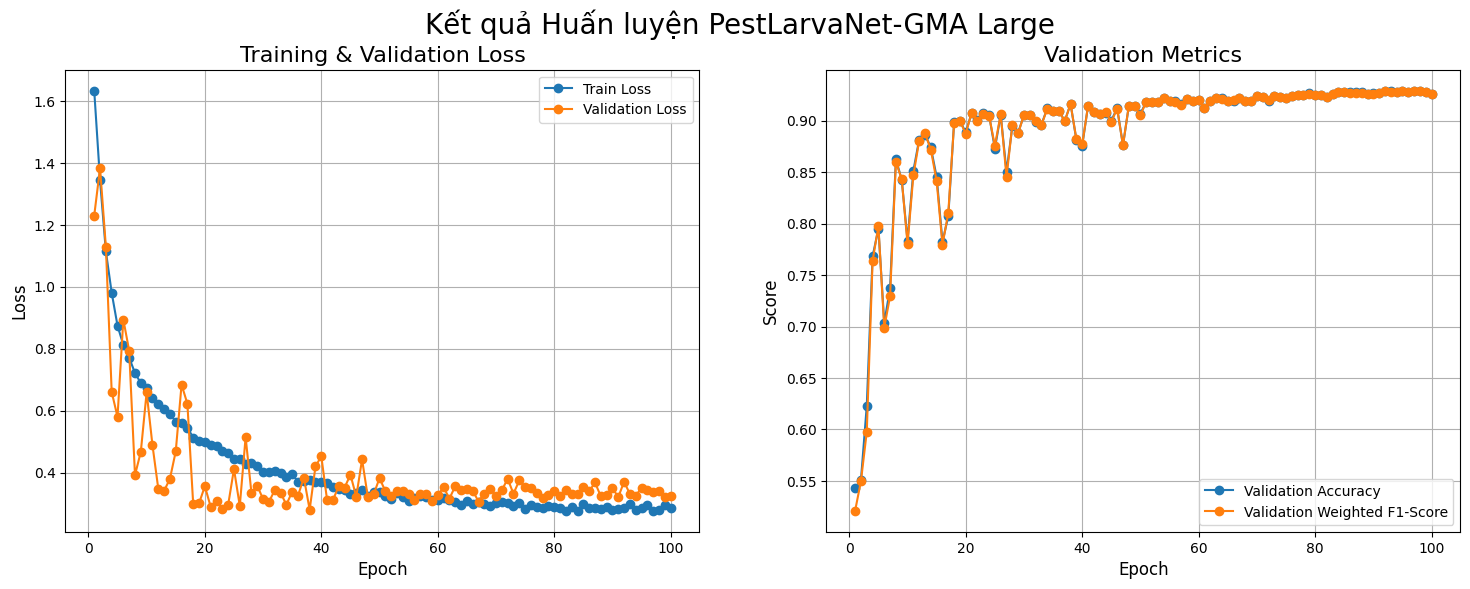


Tải trọng số model tốt nhất để vẽ Confusion Matrix.


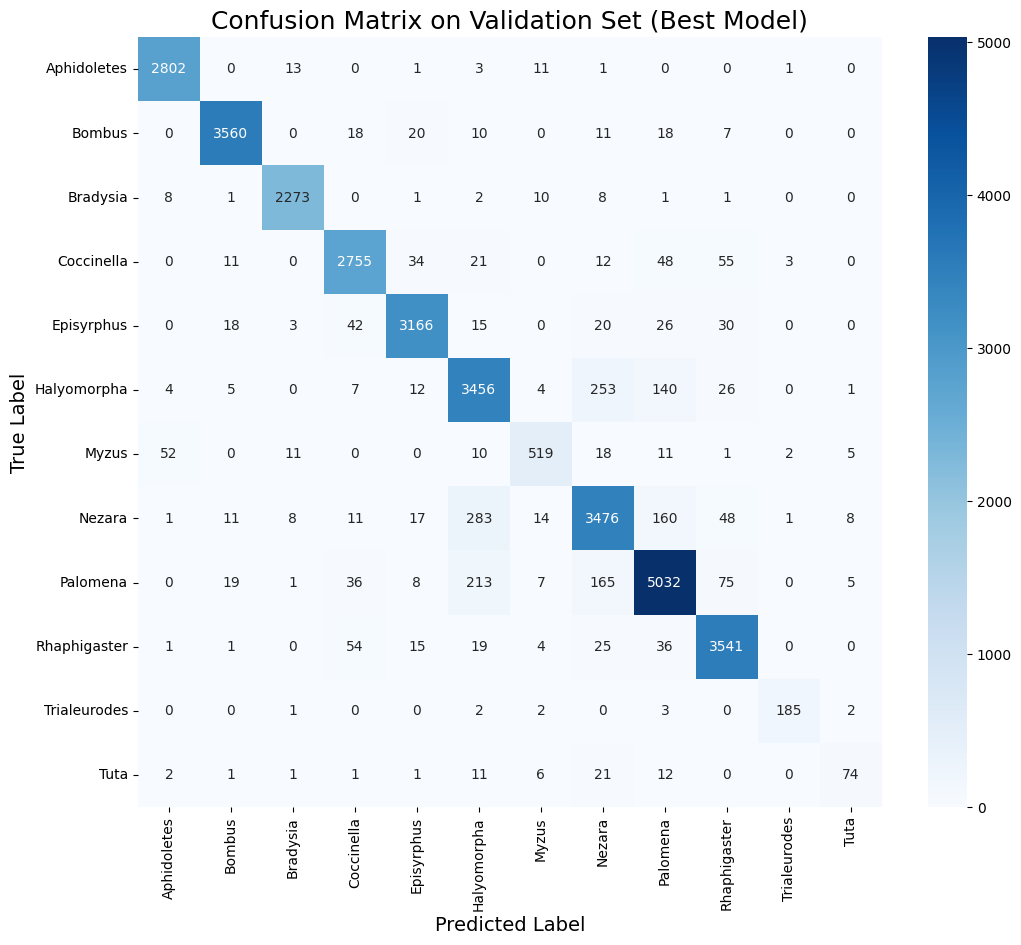

In [16]:
log_df = pd.read_csv(LOG_CSV_PATH)

# --- Vẽ biểu đồ Loss và Accuracy ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

ax1.plot(log_df['epoch'], log_df['train_loss'], label='Train Loss', marker='o')
ax1.plot(log_df['epoch'], log_df['val_loss'], label='Validation Loss', marker='o')
ax1.set_title('Training & Validation Loss', fontsize=16)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend()
ax1.grid(True)

ax2.plot(log_df['epoch'], log_df['accuracy'], label='Validation Accuracy', marker='o')
ax2.plot(log_df['epoch'], log_df['weighted_f1'], label='Validation Weighted F1-Score', marker='o')
ax2.set_title('Validation Metrics', fontsize=16)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Score', fontsize=12)
ax2.legend()
ax2.grid(True)

plt.suptitle('Kết quả Huấn luyện PestLarvaNet-GMA Large', fontsize=20)
plt.show()

# --- Vẽ Ma trận nhầm lẫn (Confusion Matrix) ---
# Tải lại trọng số của model tốt nhất để đánh giá
best_model_path = os.path.join(CHECKPOINT_DIR, 'best_model.pth')
if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    print("\nTải trọng số model tốt nhất để vẽ Confusion Matrix.")
    
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        if -1 in labels: continue
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=full_dataset.class_names, 
            yticklabels=full_dataset.class_names)
plt.title('Confusion Matrix on Validation Set (Best Model)', fontsize=18)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.show()